##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [0]:
# ==============================================================================
# PyData Pune Talk on "Transfer Learning using Pretrained Models", 5th Oct 2019
#
# Modifications to original example shared on TensolFlow Hub:
#
# 1. Simplification with just bare minimum code to demonstrate application
#    of TF Hub pretrained models for "any target task" 
#
# 2. Target tasks Demonstrated - classification of Flowers Dataset
#
# 3. Target tasks Demonstrated - classification of Sentiments in IMDB  Dataset
#
# ==============================================================================

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Text Classification Example

IMDB Movie Review classification
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task from Mass et al. The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

### Preparing the environment

In [4]:
# Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

## Getting Target Dataset



In [5]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 7s 0us/step


,sentence,sentiment,polarity
0,"Soon Americans would swarm over a darkened, da...",8,1
1,"Deathtrap gives you a twist at every turn, eve...",9,1
2,I've given 'Kôhî jikô' a low score not because...,2,0
3,I had the opportunity to see this film twice a...,10,1
4,"Well, as Goethe once said, there really isn't ...",1,0


## Preparing the Model for Target Task
We will prepare the model with tensorflow estimators. An [Estimator framework](https://www.tensorflow.org/get_started/premade_estimators#overview_of_programming_with_estimators) is TensorFlow's high-level representation of a complete model. It provides [input functions](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that wrap Pandas dataframes.

For our target dataset, the output label is "polarity", 0 means negative and 1 means "positive" review. We create the inpt functions for training and predicting as follows:

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

### Feature columns: TF Hub's way of using pretrained models

TF-Hub provides a [feature column](https://github.com/tensorflow/hub/blob/master/docs/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. 

For our example, we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1) as "Source" Pretrained Model from which we are going to borrow features for transfer learning. 

The nnlm-en-dim128 module is trained on Google News dataset. This module-

* takes **a batch of sentences in a 1-D tensor of strings** as input.
* is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).


In [0]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")


### Estimator - Creating the target model with feature columns 

We now  prepare the target model with tensorflow estimators. 

For classification, we can use a [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)

We will use the learned features columns (from source model)  while creating the model.  

In [0]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### Training the Target model

Train the estimator for a reasonable amount of steps.

In [9]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

### Prediction

Run predictions for both training and test set.

In [10]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8006399869918823
Test set accuracy: 0.7937600016593933


### Assessing Predictions: Confusion matrix

We can visually check the confusion matrix to understand the distribution of misclassifications.

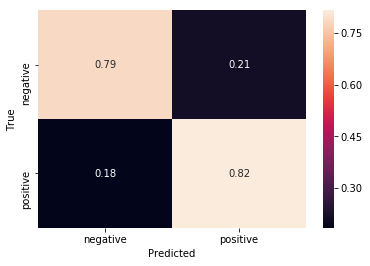

In [11]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# Image Classification Example

Flowers classification

## Preparing Environment

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow is already loaded. Please restart the runtime to change versions.


In [13]:
!pip install -U tensorflow_hub
import tensorflow_hub as hub

from tensorflow.keras import layers

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.6.0)


## Getting the Source Model: An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [15]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run source model on a example image

Download a single image to try the model on.

65536/61306 [================================] - 0s 0us/step


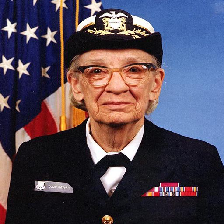

In [16]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [17]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [18]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [19]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

Since We have the predicted class ID, it does not make immediate sense as to what the prediction 653 mean. 
So we fetch the `ImageNet` labels, and decode the predictions

In [20]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [21]:
print(imagenet_labels[600:700])

['honeycomb' 'hook' 'hoopskirt' 'horizontal bar' 'horse cart' 'hourglass'
 'iPod' 'iron' "jack-o'-lantern" 'jean' 'jeep' 'jersey' 'jigsaw puzzle'
 'jinrikisha' 'joystick' 'kimono' 'knee pad' 'knot' 'lab coat' 'ladle'
 'lampshade' 'laptop' 'lawn mower' 'lens cap' 'letter opener' 'library'
 'lifeboat' 'lighter' 'limousine' 'liner' 'lipstick' 'Loafer' 'lotion'
 'loudspeaker' 'loupe' 'lumbermill' 'magnetic compass' 'mailbag' 'mailbox'
 'maillot' 'maillot' 'manhole cover' 'maraca' 'marimba' 'mask'
 'matchstick' 'maypole' 'maze' 'measuring cup' 'medicine chest' 'megalith'
 'microphone' 'microwave' 'military uniform' 'milk can' 'minibus'
 'miniskirt' 'minivan' 'missile' 'mitten' 'mixing bowl' 'mobile home'
 'Model T' 'modem' 'monastery' 'monitor' 'moped' 'mortar' 'mortarboard'
 'mosque' 'mosquito net' 'motor scooter' 'mountain bike' 'mountain tent'
 'mouse' 'mousetrap' 'moving van' 'muzzle' 'nail' 'neck brace' 'necklace'
 'nipple' 'notebook' 'obelisk' 'oboe' 'ocarina' 'odometer' 'oil filter'


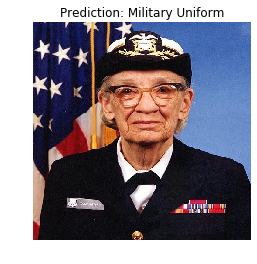

In [22]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Getting the target Dataset "Flowers"

 For this example you will use the TensorFlow flowers dataset:

In [23]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [24]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [25]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [26]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [27]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'vase', 'bubble', 'wool', 'acorn', 'cardoon', 'maze',
       'vase', 'bell pepper', 'pot', 'bee', 'daisy', 'hip',
       'picket fence', 'earthstar', 'bee', 'daisy', 'mushroom', 'daisy',
       'hay', 'daisy', 'pot', 'hummingbird', 'daisy', 'daisy', 'vase',
       'daisy', 'vase', 'daisy', 'daisy', 'daisy', 'bee'], dtype='<U30')

Now check how these predictions line up with the images:

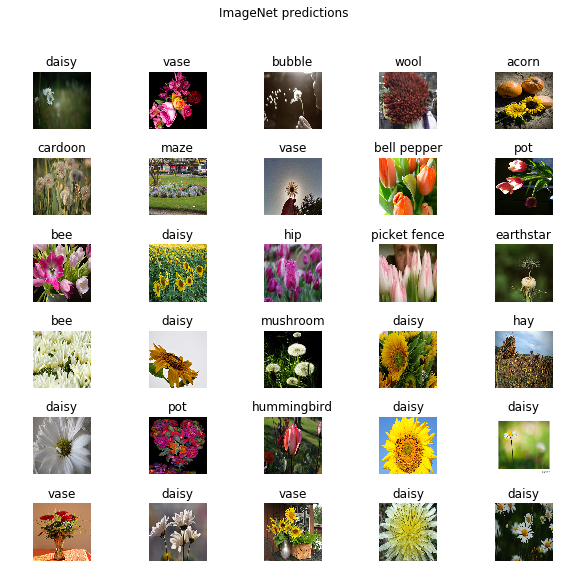

In [28]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

**The results are far from perfect**, as the source odel is trained on ImageNet which does not have several different species of flowers. So the predictions are reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the feature extractor.

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [31]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [0]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [33]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
predictions = model(image_batch)

In [35]:
predictions.shape

TensorShape([Dimension(32), Dimension(5)])

### Train the model

Use compile to configure the training process:

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [38]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 16s 136ms/step - loss: 0.6432 - acc: 0.7812
Epoch 2/2
115/115 [==============================] - 15s 127ms/step - loss: 0.3287 - acc: 0.9062


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

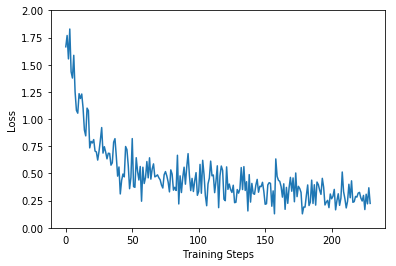

In [39]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

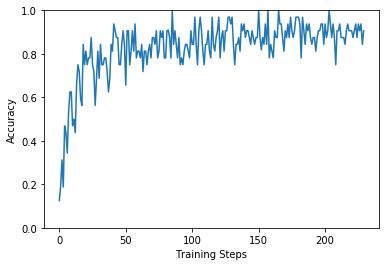

In [40]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [41]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [0]:
label_id = np.argmax(label_batch, axis=-1)

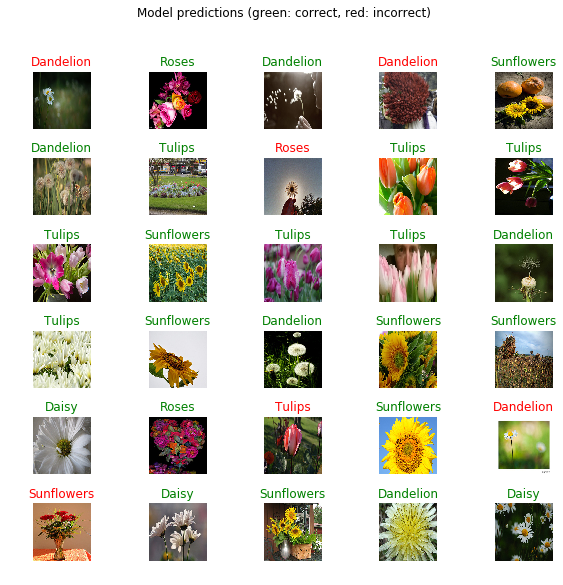

In [44]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")